**novelty detection**:
The training data is not polluted by outliers, and we are interested in detecting anomalies in new observations.

**outlier detection**:
The training data contains outliers, and we need to fit the central mode of the training data, ignoring the deviant observations.

In [14]:
!source activate py2


CondaEnvironmentNotFoundError: Could not find environment: py2 .
You can list all discoverable environments with `conda info --envs`.



In [15]:
#!/anaconda3/envs/py2/bin/pip install cvxopt

In [16]:
import numpy as np
from cvxopt import solvers, lapack, matrix, spmatrix
solvers.options['show_progress'] = 0
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline

## Generate Data

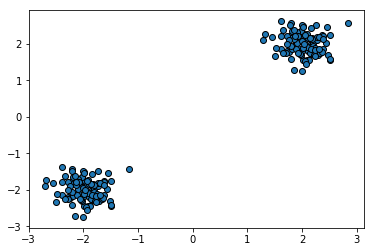

In [118]:
X = 0.3 * np.random.randn(100, 2)
X = np.r_[X + 2, X - 2]

#X = np.random.multivariate_normal([0,0],np.eye(2), 200)

def plot(X):
    plt.scatter(X[:,0], X[:,1], edgecolors  = 'black')
    pass

plot(X)


## Algorithms

### Basic solution : solving the dual by Quadratic Programming

\begin{aligned}
& \min_\alpha \frac{1}{2} \sum_{i,j} \alpha_i\alpha_j k(x_i,x_j) \\
& s.t. \ 0 \leq \alpha_i \leq \frac{1}{n \nu}, \ \sum_i \alpha_i = 1
\end{aligned}
In matrix form : 
\begin{aligned}
& \min_\alpha \frac{1}{2} \alpha^\top K \alpha \\ & s.t. \ 0 \leq \alpha \leq \frac{1}{n\nu}, \ 1^\top \alpha = 1
\end{aligned}

QP in standard form :

\begin{aligned}
& \min_x \frac{1}{2} x^\top P x + q^\top x \\
& s.t. \ Gx \leq h, \ Ax = b
\end{aligned}

In [18]:
a = np.random.randint(0,9, (2,2))
np.concatenate([a,a], axis = 0)

array([[0, 3],
       [7, 2],
       [0, 3],
       [7, 2]])

In [19]:
def RBF_Kernel(X, sigma2, Y = None):
    " Compute the RBF kernel matrix of X"
    from sklearn.metrics.pairwise import euclidean_distances
    
    if type(Y)==type(None):
        Y = X
    
    K = euclidean_distances(X,Y, squared=True)
    K *= -1./sigma2
    K = np.exp(K)
    return K

In [20]:
def fit(X, nu, sigma2):
    n = X.shape[0]
    K = RBF_Kernel(X, sigma2)
    
    P = matrix(K, tc = 'd')
    q = matrix([0]*n, tc = 'd')
    G = matrix(np.concatenate([np.eye(n),-np.eye(n)], axis = 0), tc = 'd')
    h_value = [1./(n * nu)]*n
    h_value.extend([0]*n)
    h = matrix(h_value, tc = 'd')
    A = matrix(np.reshape([1]*n, (1,n)), tc = 'd')
    b = matrix(1, tc = 'd')
    
    sol = solvers.qp(P,q,G,h,A,b)
    alpha = np.array(sol['x'])
    ix_in = np.where((alpha > 1e-5) & (alpha < 1./(n*nu)))[0][0]
    rho = np.transpose(np.dot(np.reshape(alpha, (1,n)), K[:,ix_in]))

    return alpha, rho

def predict(X, newData, alpha, rho, sigma2):
    n = X.shape[0]
    K = RBF_Kernel(X, sigma2, newData)
    return np.transpose(np.dot(np.reshape(alpha, (1,n)), K) - rho)

In [21]:
def get_grid(X, step = 0.05):
    x_axis = np.arange(min(X[:,0])-step,max(X[:,0])+2*step,step)
    y_axis = np.arange(min(X[:,1])-step,max(X[:,1])+2*step,step)

    my_grid = []
    for i in x_axis:
        for j in y_axis:
            my_grid.append([i,j])#,1])
    my_grid = np.array(my_grid)
    
    return x_axis, y_axis, my_grid

def Normalize_Pred(pred):    
    pred_100 = pred -np.min(pred)
    pred_100 = (pred_100 / np.max(pred_100)) * 100
    return pred_100

def get_delim(pred_100, x_axis, y_axis, eps = 0):
    ix_delim = np.where((pred_100  < eps) & (pred_100  > -eps))[0]
    x_delim = []
    y_delim = []
    for i in range(len(ix_delim)):
        a, b = np.divmod(ix_delim[i],len(y_axis))
        x_delim.append(x_axis[a])
        y_delim.append(y_axis[b])
    return x_delim, y_delim

def plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = 0.05):
    norm_colors = mpl.colors.Normalize(vmin=0,vmax=100)
    X_axis, Y_axis = np.meshgrid(x_axis, y_axis)
    C = np.transpose(pred_100.reshape((len(x_axis), len(y_axis))))
    plt.pcolor(X_axis, Y_axis, C, norm= norm_colors, cmap = 'YlOrRd')
    plt.scatter(x_delim, y_delim, c = 'black', s = 10)
    plot(X)
    plt.xlim((min(X[:,0])-step,max(X[:,0])+step))
    plt.ylim((min(X[:,1])-step,max(X[:,1])+step))
    pass

def plot_pred_plan(X, alpha, rho, sigma2, step = 0.05, eps = 0):
    x_axis, y_axis, my_grid = get_grid(X, step)
    pred = predict(X, my_grid, alpha, rho, sigma2)
    x_delim, y_delim = get_delim(pred, x_axis, y_axis, eps)
    pred_100 = Normalize_Pred(pred)
    plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step)
    return pred

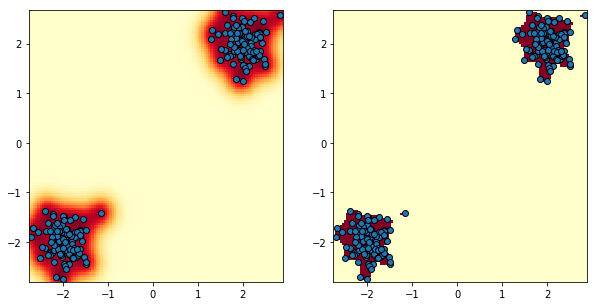

In [119]:
step = 0.05
nu = 0.1
sigma2 = 0.1

alpha, rho = fit(X, nu, sigma2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
pred = plot_pred_plan(X, alpha, rho, sigma2, step = step)

plt.subplot(1,2,2)
x_axis, y_axis, my_grid = get_grid(X, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)

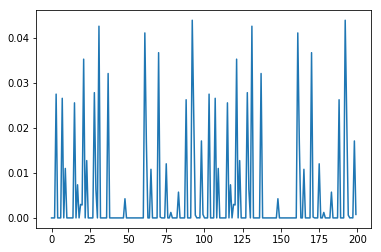

In [44]:
plt.plot(alpha)

### Better solution : SMO variant

### Application to real data

#### Stamps data

In [221]:
import pandas as pd
df = pd.read_csv("stamps.txt",sep="\t",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.112011,0.425226,0.424364,0.681209,0.748623,0.066976,0.865725,0.020741,0.181869,1
1,0.000000,0.425226,0.043612,0.086249,0.122159,0.000000,0.889814,1.000000,0.969187,1
2,0.119357,0.425226,0.280526,0.587800,0.696619,0.014433,0.980303,0.367449,0.595861,1
3,0.024987,0.425226,0.056383,0.097072,0.130242,0.001800,0.787256,0.284758,0.804989,1
4,0.176667,0.425226,0.356267,0.515091,0.555632,0.059072,0.881087,0.006373,0.124229,1


data source: http://cs.au.dk/~barbora/outDet.html

In [222]:
print("% of outlier:",len(df[df[9]==1])/len(df))

% of outlier: 0.09117647058823529


In [453]:
X=np.array(df.iloc[:,:9])
y=np.array(df.iloc[:,9])
y[y==1]=-1
y[y==0]=1

#split the data into train/test
ind = np.random.choice(np.arange(0,len(X)),int(len(X)*0.7),replace=False)
ind_test = np.setdiff1d(np.arange(0,len(X)),ind)
#separate the data in train and test
X_test,y_test=X[ind_test,:],y[ind_test]
X_train,y_train=X[ind,:],y[ind]

In [454]:
nu=0.08
sigma2=2
alpha, rho = fit(X_train, nu, sigma2)

In [455]:
y_pred = np.sign(predict(X_train, X_test, alpha, rho, sigma2)).flatten()

In [456]:
print("share of outliers on test set:",len(y_test[y_test==-1])/len(y_test))

share of outliers on test set: 0.11650485436893204


In [457]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 3  9]
 [ 6 85]]
             precision    recall  f1-score   support

         -1       0.33      0.25      0.29        12
          1       0.90      0.93      0.92        91

avg / total       0.84      0.85      0.85       103



#### Letter recognition dataset

data source: http://odds.cs.stonybrook.edu/letter-recognition-dataset/

In [526]:
from scipy.io import loadmat
x = loadmat('letter.mat')

In [527]:
X=x['X']
y=x['y'].flatten()
y=y.astype(float)
X=X.astype(int)
y[y==1]=-1
y[y==0]=1
#split the data into train/test
ind = np.random.choice(np.arange(0,len(X)),int(len(X)*0.7),replace=False)
ind_test = np.setdiff1d(np.arange(0,len(X)),ind)
#separate the data in train and test
X_test,y_test=X[ind_test,:],y[ind_test]
X_train,y_train=X[ind,:],y[ind]

In [542]:
nu=0.8
sigma2=50
alpha, rho = fit(X_train, nu, sigma2)
y_pred = np.sign(predict(X_train, X_test, alpha, rho, sigma2)).flatten()

In [543]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 19  13]
 [100 348]]
             precision    recall  f1-score   support

       -1.0       0.16      0.59      0.25        32
        1.0       0.96      0.78      0.86       448

avg / total       0.91      0.76      0.82       480

